<a href="https://colab.research.google.com/github/mindang/pytorch-master/blob/main/1_8%EC%9E%A5_%EC%BB%A8%EB%B3%BC%EB%A3%A8%EC%85%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!는 한줄씩 실행되도록 !가 없으면 오류 발생
!pip3 install torch
!pip3 install torchvision

In [15]:
#%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

#데이터셋 불러오기

In [16]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified
Files already downloaded and verified


In [17]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

#컨볼루션 테스트

In [18]:
img , _ = cifar2[99]

conv = nn.Conv2d(3,16,kernel_size=3)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape , output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

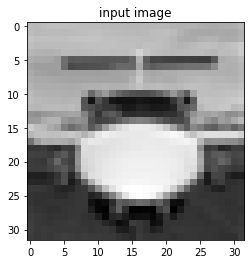

In [19]:
plt.imshow(img.mean(0), cmap='gray')
plt.title("input image")
plt.show()

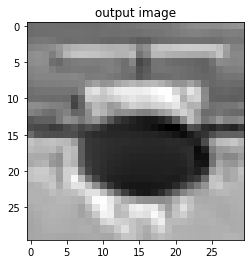

In [20]:
#[0,x] 현재 output이미지는 16개의 차원으로 이루어져 있다 x로 원하는 차원의 이미지를 선택 가능
plt.imshow(output[0,0].detach(), cmap='gray')
plt.title("output image")
plt.show()

In [21]:
#패딩 사용
img , _ = cifar2[99]

conv = nn.Conv2d(3,16,kernel_size=3,padding = 1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape , output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 32, 32]))

In [22]:
list(conv.parameters())

[Parameter containing:
 tensor([[[[-0.1502,  0.0521, -0.0493],
           [-0.1704,  0.0751,  0.0680],
           [ 0.0259,  0.1258, -0.0773]],
 
          [[ 0.1757, -0.1467,  0.1735],
           [ 0.1430, -0.1712, -0.0171],
           [-0.1035,  0.1894, -0.0080]],
 
          [[ 0.1134,  0.1664, -0.1484],
           [ 0.1170, -0.1674, -0.0520],
           [-0.0776, -0.1800, -0.1813]]],
 
 
         [[[-0.1855, -0.1489, -0.1075],
           [-0.0634,  0.1077, -0.0309],
           [-0.1905, -0.1398,  0.1381]],
 
          [[-0.1878, -0.0947, -0.1742],
           [ 0.1035,  0.1315,  0.0168],
           [-0.0967, -0.0467,  0.0112]],
 
          [[ 0.0807,  0.0033, -0.0897],
           [ 0.0093,  0.0059,  0.0018],
           [ 0.0837, -0.0725,  0.0121]]],
 
 
         [[[ 0.0008,  0.0812, -0.1178],
           [-0.1505, -0.1566,  0.0809],
           [ 0.1531,  0.1909,  0.0687]],
 
          [[-0.0392,  0.0354, -0.1903],
           [ 0.0222, -0.0635, -0.0146],
           [ 0.1105, -0.0662, 

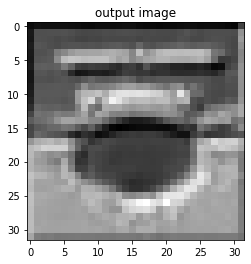

In [23]:
plt.imshow(output[0,0].detach(), cmap='gray')
plt.title("output image")
plt.show()

#커널에 따른 출력의 변화


In [24]:
#커널 가중치 비율이 모두 같음 => 이웃 픽셀의 평균을 갖음
conv = nn.Conv2d(3,1,kernel_size=3,padding=1)
with torch.no_grad():
  conv.bias.zero_()
  conv.weight.fill_(1.0/9.0)
  #위와 같은 의미 conv.weight.one_()

img , _ = cifar2[99]
output = conv(img.unsqueeze(0))
print(img.unsqueeze(0).shape,output.shape)

torch.Size([1, 3, 32, 32]) torch.Size([1, 1, 32, 32])


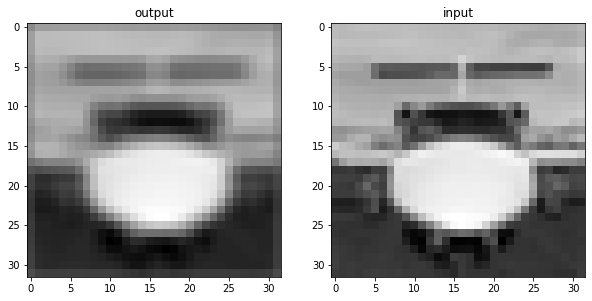

In [25]:
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.show()
#이웃 픽셀의 평균이 되므로 흐릿해짐

In [26]:
#커널 가중치 변경 => 오른쪽 픽셀에서 왼쪽 픽셀을 뺌
conv = nn.Conv2d(3,1,kernel_size=3,padding=1)
with torch.no_grad():
  conv.bias.zero_()
  conv.weight[:] = torch.tensor([[-1.0 , 0.0 , 1.0],
                              [-1.0 , 0.0 , 1.0],
                              [-1.0 , 0.0 , 1.0]])

img , _ = cifar2[99]
output = conv(img.unsqueeze(0))
print(img.unsqueeze(0).shape,output.shape)

torch.Size([1, 3, 32, 32]) torch.Size([1, 1, 32, 32])


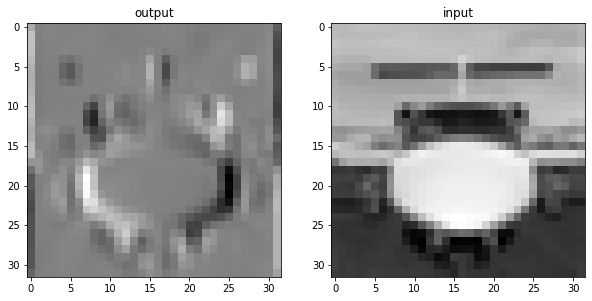

In [27]:
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.show()
#비슷한 영역에서는 값이 0 , 경계에선 값이 높아짐 즉, 인접한 두 영역의 수직 경계를 탐색

#픽셀이 큰 객체를 탐지하기  
1. 커널 사이즈를 키운다 -> 완전 연결망의 아핀 변환으로 수렴 함(컨볼루션 장점을 잃음)  
2. 풀링을 이용하여 지역성 넓히기 -> 다운샘플링  

In [28]:
#평균 풀링은 초창기 많이 사용
#추세는 맥스 풀링임 / 단점은 데이터의 3/4를 버림
#(3x4)컨볼루션을 스트라이드 2 => 가능성은 있지만 맥스풀링이 대세
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))
print(img.unsqueeze(0).shape,output.shape)

torch.Size([1, 3, 32, 32]) torch.Size([1, 3, 16, 16])


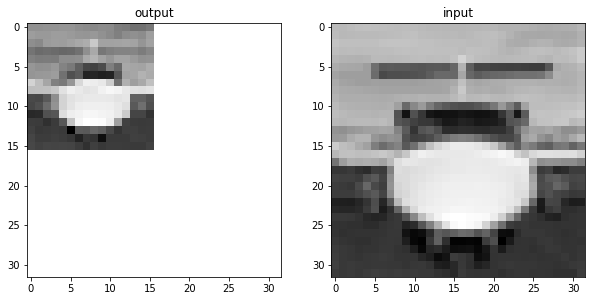

In [29]:
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.show()
#비슷한 영역에서는 값이 0 , 경계에선 값이 높아짐 즉, 인접한 두 영역의 수직 경계를 탐색

#conv + MaxPooling

In [30]:
#sequential을 이용하여 편하게 모델 생성
model = nn.Sequential(
     nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2),
            nn.Softmax()
)

img , _ = cifar2[99]
output = model(img.unsqueeze(0))
output

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([[0.4965, 0.5035]], grad_fn=<SoftmaxBackward0>)

In [31]:
#직접 모듈 만들기 / 지원하지 않는 기능을 써야할 때
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # Flatten기능
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out



#함수형 API를 사용하여 더 간결하게 변경
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [32]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.0596,  0.0296]], grad_fn=<AddmmBackward0>)

#훈련 시작

In [33]:
import datetime  # <1>

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):  
        loss_train = 0.0
        for imgs, labels in train_loader:  # 데이터셋 순회
            
            outputs = model(imgs)  # 모델에 배치 넣기
            
            loss = loss_fn(outputs, labels)  # 손실 값 계싼

            optimizer.zero_grad()  # 이전 기울기 값 제거 , 기울기 값 초기화
            
            loss.backward()  # 역전파 수행 , 모든 파라미터에 대한 기울기 계산
            
            optimizer.step()  # 모델 업데이트

            loss_train += loss.item()  # item을 이용하여 파이썬 수로 변환

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [34]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)  

model = Net()  # 신경망 , 모델 초기화
optimizer = optim.SGD(model.parameters(), lr=1e-2)  
loss_fn = nn.CrossEntropyLoss()  # 

training_loop(  
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2023-01-15 16:29:10.934874 Epoch 1, Training loss 0.5727586423515514


KeyboardInterrupt: ignored

In [ ]:
#정확도 측정
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # 파라미터 업데이트를 하지 않을 것이므로 기울기는 필요없음
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # 가장 높은 인덱스 출력
                total += labels.shape[0]  
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

In [ ]:
#모델 저장
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

#모델 불러오기
loaded_model = Net()  # <1>
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt'))

#gpu

In [44]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [43]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  # 이미지와 라벨 텐서 gpu로 보냄
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = Net().to(device=device)  # 모델(파라미터)를 gpu로 보냄
optimizer = optim.SGD(model.parameters(), lr=1e-2) #모델을 보낸 후 옵티마이저 정의
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

In [ ]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt',
                                        map_location=device))

In [38]:
def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

#파라미터화 + 드롭아웃

In [45]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [46]:
import datetime
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
validate(model, train_loader, val_loader)

2023-01-15 16:32:42.024735 Epoch 1, Training loss 0.569401436550602
2023-01-15 16:32:45.930222 Epoch 10, Training loss 0.3735391947494191
2023-01-15 16:32:50.310879 Epoch 20, Training loss 0.34523271413365747
2023-01-15 16:32:54.711544 Epoch 30, Training loss 0.32953002299093137
2023-01-15 16:32:59.120716 Epoch 40, Training loss 0.31189146932143313
2023-01-15 16:33:03.567098 Epoch 50, Training loss 0.29827113392626403
2023-01-15 16:33:07.954247 Epoch 60, Training loss 0.2895691221117214
2023-01-15 16:33:12.385795 Epoch 70, Training loss 0.27182397502622785
2023-01-15 16:33:16.763582 Epoch 80, Training loss 0.2634085770815041
2023-01-15 16:33:21.177030 Epoch 90, Training loss 0.2506512782661019
2023-01-15 16:33:25.561329 Epoch 100, Training loss 0.24343881836742354
Accuracy train: 0.90
Accuracy val: 0.87


{'train': 0.9002, 'val': 0.8735}

#배치정규화

In [49]:
#배치 정규화
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, 
                               padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
validate(model, train_loader, val_loader)

2023-01-15 16:34:33.690262 Epoch 1, Training loss 0.46513135977991066
2023-01-15 16:34:37.978986 Epoch 10, Training loss 0.27437000745421003
2023-01-15 16:34:42.725215 Epoch 20, Training loss 0.21211157150708945
2023-01-15 16:34:47.501203 Epoch 30, Training loss 0.16958282273381378
2023-01-15 16:34:52.258947 Epoch 40, Training loss 0.12616684045761253
2023-01-15 16:34:57.056191 Epoch 50, Training loss 0.10442510020628476
2023-01-15 16:35:01.843023 Epoch 60, Training loss 0.07717468765131227
2023-01-15 16:35:06.621582 Epoch 70, Training loss 0.07202043155931932
2023-01-15 16:35:11.392156 Epoch 80, Training loss 0.037688881668979955
2023-01-15 16:35:16.194987 Epoch 90, Training loss 0.027624804746051123
2023-01-15 16:35:20.996607 Epoch 100, Training loss 0.022901629480373137
Accuracy train: 0.99
Accuracy val: 0.87


{'train': 0.9861, 'val': 0.874}

#스킵 커넥션(잔차 연결) : 깊은 신경만 구현 가능

In [51]:
#기본구조
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [52]:
#잔차 연결
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [54]:
model = NetRes(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
validate(model, train_loader, val_loader)

2023-01-15 16:41:59.567135 Epoch 1, Training loss 0.6603912456779722
2023-01-15 16:42:03.601170 Epoch 10, Training loss 0.3280786344200183
2023-01-15 16:42:08.029810 Epoch 20, Training loss 0.2838510543487634
2023-01-15 16:42:12.457033 Epoch 30, Training loss 0.24976138846509777
2023-01-15 16:42:16.915055 Epoch 40, Training loss 0.2180998872514743
2023-01-15 16:42:21.370926 Epoch 50, Training loss 0.18559049307161077
2023-01-15 16:42:25.866156 Epoch 60, Training loss 0.16346923575089994
2023-01-15 16:42:30.276784 Epoch 70, Training loss 0.14236082943381778
2023-01-15 16:42:34.712359 Epoch 80, Training loss 0.12075445561367236
2023-01-15 16:42:39.102360 Epoch 90, Training loss 0.09114481649913225
2023-01-15 16:42:43.508812 Epoch 100, Training loss 0.07577709181851168
Accuracy train: 0.98
Accuracy val: 0.89


{'train': 0.9826, 'val': 0.8915}

#깊은 신경망 , 블럭 구현

In [55]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)  # <1>
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')  # <2>
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out
  
model = NetResDeep(n_chans1=32, n_blocks=100).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
validate(model, train_loader, val_loader)

2023-01-15 16:56:01.464837 Epoch 1, Training loss 1.119349929177837
2023-01-15 16:57:24.111733 Epoch 10, Training loss 0.3065776473777309
2023-01-15 16:58:54.764622 Epoch 20, Training loss 0.23422263989782638
2023-01-15 17:00:25.384899 Epoch 30, Training loss 0.18428095838256703
2023-01-15 17:01:55.820166 Epoch 40, Training loss 0.13287869634427082
2023-01-15 17:03:26.256551 Epoch 50, Training loss 0.1281071768177875
2023-01-15 17:04:56.981161 Epoch 60, Training loss 0.10727429583929717
2023-01-15 17:06:28.044770 Epoch 70, Training loss 0.07641117917492417
2023-01-15 17:07:58.907472 Epoch 80, Training loss 0.09644814963811403
2023-01-15 17:09:29.519263 Epoch 90, Training loss 0.0756190644616445
2023-01-15 17:11:00.020505 Epoch 100, Training loss 0.06209423927780075
Accuracy train: 0.98
Accuracy val: 0.86


{'train': 0.9772, 'val': 0.864}

In [56]:
a = torch.tensor([1,2,3])
b = torch.tensor([4,5,6])
c = a + b
c

tensor([5, 7, 9])